## Introduction to Text Mining and NLP: Term Paper

---------------------------
Ramón Talvi

David Vallmanya

Irene Villalonga

---------------------------

In this term paper we will use Reddit's API to extract a huge number of users opinions in response to the prompt "Donald Trump has not made a single lasting positive impact on the USA during his term as president", which is included in a very popular reddit community called "Change my views". 

The project aims to analyze how the public, as represented by Reddit comments, perceive the performance of Trump's presidency in various political areas such as the economy, foreign affairs, COVID, gender, etc. The goal is to propose a logistic model that measures the relationship between a given political topic (for instance, gender) and the overall sentiment of the public on that specific topic: the idea is to measure Trump's perceived presidency performance on different political areas (topics). The model would use the topics as a covariates and the overall sentiment as the dependent variable.


### 1) WEB SCRAPING

In [3]:
import praw
import datetime
import pandas as pd
from praw.models import MoreComments

secret_token = ""
client_id = ""
username = ""
password = ""

reddit = praw.Reddit(client_id=client_id,
                     client_secret=secret_token, password=password,
                     user_agent='MyBot/0.0.1', username=username)

df = []

submission = reddit.submission(id='iq41dt')

submission.comment_sort = "best"
submission.comments.replace_more(limit=1500)

count_comments=0

for comment in submission.comments:

    if isinstance(comment, MoreComments):
        continue

    if comment.stickied == False:

        c_author = comment.author
        if c_author == None: 
            c_author = "NA"
        else:
            c_author = c_author.name

        c_replies = 0
        for reply in comment.replies:
            c_replies += 1

        c_awards = 0
        for award in comment.all_awardings:
            c_awards += 1

        df_comment = pd.DataFrame({
            'post_id': submission.id,
            'comment_id': comment.id,
            'subreddit': submission.subreddit.display_name,
            'post_title': submission.title,
            'post_ups': submission.ups,
            'post_upvote_ratio': submission.upvote_ratio,
            'post_num_comments': submission.num_comments,
            'post_time': datetime.datetime.fromtimestamp(submission.created_utc),
            'post_text': submission.selftext,
            'post_downs': submission.downs,
            'post_score': submission.score,
            'post_awards': p_awards,
            'comment_awards': c_awards,
            'comment_author': c_author,
            'body': comment.body,
            'comment_replies': c_replies,
            'comment_ups': comment.ups,
            'comment_downs': comment.downs,
            'comment_time' : datetime.datetime.fromtimestamp(comment.created_utc),
            'comment_score': comment.score
        }, index=[count_comments])

        df = pd.concat([df, df_comment])

        print("Post: "+str(count_posts) + "    Comment:"+ str(count_comments) + "    Inpost comment:" + str(i))

        count_comments += 1
    
df.to_csv("cmv_extract.csv", sep=';')
df.head()

### 2) PRE PROCESSING 
In this section we are going to first load and clean the Data Frame. Then we will carry out the usual steps in Text Mining preprocessing: tokenization, lemmatizing, remove punctuation, unify, remove stopwords, stemming. Finally we will obtain the Document Term Matrix. 

In [1]:
import os
import pandas as pd

In [2]:
# Load the dataframe

#readin = '/Users/Ramon/Documents/Estudio/BSE/Term_2/Intro_Text_Analysis/Project/writingprompts-lda-project'
readin = '/run/media/david-vp/davidvp-files/DSMMaster/intro-NLP/reddit-project/'
filename ="cmv_extract.csv"

df = pd.read_csv(os.path.join(readin, filename), sep=';', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         849 non-null    int64  
 1   post_id            849 non-null    object 
 2   comment_id         849 non-null    object 
 3   subreddit          849 non-null    object 
 4   post_title         849 non-null    object 
 5   post_ups           849 non-null    int64  
 6   post_upvote_ratio  849 non-null    float64
 7   post_num_comments  849 non-null    int64  
 8   post_time          849 non-null    object 
 9   post_text          849 non-null    object 
 10  post_downs         849 non-null    int64  
 11  post_score         849 non-null    int64  
 12  post_awards        849 non-null    int64  
 13  comment_awards     849 non-null    int64  
 14  comment_author     647 non-null    object 
 15  body               849 non-null    object 
 16  comment_replies    849 non

In [3]:
# Remove NA 
df = df.loc[df['body'] != '[removed]']
df = df.dropna(subset=['body']) 

df = df.reset_index(drop=True) 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         736 non-null    int64  
 1   post_id            736 non-null    object 
 2   comment_id         736 non-null    object 
 3   subreddit          736 non-null    object 
 4   post_title         736 non-null    object 
 5   post_ups           736 non-null    int64  
 6   post_upvote_ratio  736 non-null    float64
 7   post_num_comments  736 non-null    int64  
 8   post_time          736 non-null    object 
 9   post_text          736 non-null    object 
 10  post_downs         736 non-null    int64  
 11  post_score         736 non-null    int64  
 12  post_awards        736 non-null    int64  
 13  comment_awards     736 non-null    int64  
 14  comment_author     647 non-null    object 
 15  body               736 non-null    object 
 16  comment_replies    736 non

In [4]:
print("Post Title: \n", df.post_title[0])
print("   ")
print("Text 1 : \n", df.body[0])
print("   ")
print("Text 2 : \n", df.body[1])
print("   ")
print("Text 3 : \n", df.body[2])

Post Title: 
 CMV: Donald Trump has not made a single lasting positive impact on the USA during his term as president.
   
Text 1 : 
 How about his signing into law of "right-to-try" legislation, allowing gravely ill patients access to experimental drugs?
   
Text 2 : 
 I haven't seen this posted yet - but by far his most important accomplishment has been keeping America out of any new foreign conflicts. [According to this article](https://www.theelders.org/news/only-us-president-who-didnt-wage-war), the only other president who managed to keep the US out of new foreign conflicts was Jimmy Carter. Thus if this holds through the rest of his term, Trump will be only the second to manage that.

For all the talk about Trump being an idiot, and dangerous, and in over his head, I'd submit that keeping the US out of other people's wars is not an easy thing to do. I think he deserves an enormous amount of respect for having pulled this off.
   
Text 3 : 
 Doubling the standard deduction on tax

Note that from a unique post title: " Donald Trump has not made a single lasting positive impact on the USA during his term as president" we have extracted 736 user's opinions. 

First, we are going to preprocess this texts and obtain the document term matrix.

In [5]:
import re
import nltk                                                             # Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 
my_stopwords = ['com', 'reddit', 'http', 'wiki', 'www', 'im', 'trump', 'lol', 'people', 'expand',
                'really', 'deal','u', 'much', 'get', 'good', 'act', 'put', 'man', 'a', 'think', 'one',
                'say', 'like', 'go', 'do', 'head', 'yet', 'wall', 'guess', 'keep', 'oh', 'north', 'oil',
                'prize', 'involved', 'might', 'medium''among', 'might', 'make', 'do', 'may', 'year', 'give',
                'also', 'law', 'etc', 'wait', 'prove', 'mean', 'thing', 'rest', 'middle','rnr','u','fuck','make','would']
stop_words.update(my_stopwords)

from tqdm import tqdm
tqdm.pandas()

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                if modulation==0:
                    stems.append(lowers)
                stems.append(" ")
    return "".join(stems)

In [6]:
mod=2 #=1 means stemming, =2 means lemmatizing, =0 just lowercase

text_preproc = (
    df.body
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

df_proc = df
df_proc["text_preproc"]=text_preproc

print("done with text")

100%|████████████████████████████████| 736/736 [00:01<00:00, 644.96it/s]

done with text


In [7]:
for article in df.text_preproc[:1]:
    print(article)

signing right try legislation allowing gravely ill patient access experimental drug 


In [8]:
Texts = df_proc.text_preproc.tolist()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Without tf-idf 
cv = CountVectorizer(ngram_range = (1,2))
cv.fit(Texts)
vectorized_text=cv.transform(Texts)
names=np.array(cv.get_feature_names())
print("dimensions of DT matrix are", vectorized_text.shape)

dimensions of DT matrix are (736, 24513)


/home/david-vp/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
dtm = pd.DataFrame.sparse.from_spmatrix(vectorized_text)
dtm.head()

,0,1,2,3,4,5,6,7,8,9,...,24503,24504,24505,24506,24507,24508,24509,24510,24511,24512
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

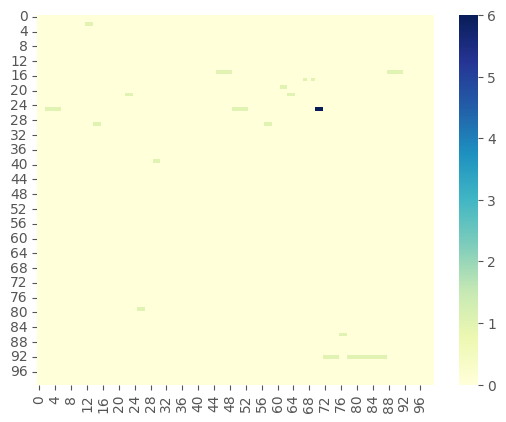

In [40]:
import seaborn as sns
import pandas as pd

# Heat matrix from Document Term Matrix
sns.heatmap(dtm.iloc[:100, :100], cmap='YlGnBu')

### 3) POST PROCESSING
In this section we are going to use both the term frequency and the inverse document frequency to reweight the terms in the document term matrix. 

In [11]:
# Try if tf-idf 
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(ngram_range = (1,2), norm=None)
cv.fit(Texts)
vectorized_text=cv.transform(Texts)
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)



document term matrix has size (736, 24513)


### 4A) LDA IMPLEMENTATION 

In [12]:
# Basics
import re                                                              
import os                                                              
import numpy as np
import pandas as pd

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt                                        
import matplotlib.animation as animation
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Misc
from tqdm import tqdm                                                 
tqdm.pandas()
import scipy.stats as stats

#gensim
import gensim
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from collections import defaultdict

from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/david-
[nltk_data]     vp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/david-vp/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david-vp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
len(Texts)

736

In [14]:
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'

def preprocess(text):
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]

[nltk_data] Downloading package omw-1.4 to /home/david-vp/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/david-vp/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [15]:
corp = [preprocess(line) for line in Texts]

In [16]:
dictionary = gensim.corpora.Dictionary(corp)
len(dictionary)

4617

In [17]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)

In [18]:
bow = [dictionary.doc2bow(line) for line in corp]

In [19]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) 
              for t in range(ntopics) 
              for w,p in model.get_topic_terms(t, topn=1)]
              
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

In [20]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha=1, per_word_topics=True)
    # visuzlize the model term topics
    #viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=4)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(Texts,bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
    return model

In [21]:
test_eta('auto', dictionary, ntopics=5)

Perplexity: -5.95
Topic 0: ['sign', 'bill', 'make', 'well']
Topic 1: ['tax', 'american', 'administration', 'job']
Topic 2: ['positive', 'president', 'do', 'impact']
Topic 3: ['obama', 'china', 'peace', 'u']
Topic 4: ['change', 'bad', 'see', 'know']
signing right try legislation allowing gravely ill patient access experimental drug  ['(0, 50.1%)', '(1, 19.6%)', '(2, 9.1%)', '(3, 10.2%)', '(4, 11.0%)']
seen posted far important accomplishment keeping america new foreign conflict according article http theelders org news u president didnt wage war president managed US new foreign conflict jimmy carter thus hold term second manage talk idiot dangerous submit keeping US war easy deserves enormous amount respect pulled  ['(0, 6.8%)', '(1, 17.4%)', '(2, 15.6%)', '(3, 42.2%)', '(4, 18.1%)']
doubling standard deduction tax absolutely net positive country previously rarely 12k line unless used mortgage interest deduction itemizing unfairly balanced towards home owner previously benefited hurt le

In [22]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [23]:
apriori_original = {
    'war':0,'peace':0,'military':0,
    'tax':1,'cut':1,'business':1, 
    'economy':2, 'employment':2, 'growth':2, 'unemployment':2,
    'virus':3, 'pandemia':3, 'virus':3,'coronavirus':3,
    'media':4, 'news':4,
    'china':5
}
eta = create_eta(apriori_original, dictionary, 8)
test_eta(eta, dictionary, 8)

Perplexity: -4.63
Topic 0: ['sign', 'bill', 'order', 'care']
Topic 1: ['tax', 'american', 'job', 'low']
Topic 2: ['president', 'war', 'time', 'since']
Topic 3: ['china', 'u', 'peace', 'world']
Topic 4: ['change', 'get', 'america', 'country']
Topic 5: ['positive', 'make', 'do', 'see']
Topic 6: ['bad', 'right', 'way', 'something']
Topic 7: ['even', 'obama', 'know', 'look']
signing right try legislation allowing gravely ill patient access experimental drug  ['(0, 41.8%)', '(1, 7.8%)', '(2, 7.6%)', '(3, 7.1%)', '(4, 7.4%)', '(5, 7.1%)', '(6, 14.0%)', '(7, 7.1%)']
seen posted far important accomplishment keeping america new foreign conflict according article http theelders org news u president didnt wage war president managed US new foreign conflict jimmy carter thus hold term second manage talk idiot dangerous submit keeping US war easy deserves enormous amount respect pulled  ['(0, 2.8%)', '(1, 12.0%)', '(2, 20.2%)', '(3, 23.7%)', '(4, 3.4%)', '(5, 15.4%)', '(6, 5.6%)', '(7, 16.9%)']
doub

In [24]:
# sacar matriz con filas: textos y columnas topics; entradas probabilidiad de que ese texto sea de un topic


### 4B) SENTIMENT ANALYSIS 

In [36]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# instructions
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm
# pip install spacytextblob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

texts = df['text_preproc']
polarities = []
subjectivities = []

for text in texts:
    doc = nlp(text)
    polarity = doc._.blob.polarity
    polarities.append(polarity)
    subjectivity = doc._.blob.subjectivity
    subjectivities.append(subjectivity)

df['sentiment'] = polarities
df['subjectivity'] = subjectivities

### 5) LOGISTIC REGRESSION ANALYSIS

### 6) POSSIBLE EXTENSIONS 